# Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



In [72]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable


In [73]:
import pandas as pd
import requests
import zipfile
import io, os

# id archiwum dla poszczególnych lat
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
gios_url_ids = {2014: '302', 2019: '322', 2024: '582'}
gios_pm25_file = {2014: '2014_PM2.5_1g.xlsx', 2019: '2019_PM25_1g.xlsx', 2024: '2024_PM25_1g.xlsx'}

# funkcja do ściągania podanego archiwum
def download_gios_archive(year, gios_id, filename):
    # Pobranie archiwum ZIP do pamięci
    url = f"{gios_archive_url}{gios_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj
    
    # Otwórz zip w pamięci
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # znajdź właściwy plik z PM2.5
        if not filename:
            print(f"Błąd: nie znaleziono {filename}.")
        else:
            # wczytaj plik do pandas
            with z.open(filename) as f:
                try:
                    df = pd.read_excel(f, header=None)
                except Exception as e:
                    print(f"Błąd przy wczytywaniu {year}: {e}")
    return df

# Przykladowe użycie
#df2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])

In [74]:
# Pobieram dane z użyciem funkcji:
df2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])
df2019 = download_gios_archive(2019, gios_url_ids[2019], gios_pm25_file[2019])
df2014 = download_gios_archive(2014, gios_url_ids[2014], gios_pm25_file[2014])

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## Zadanie 1 - Zofia Rewak


In [75]:
for rok, df in zip([2014, 2019, 2024], [df2014, df2019, df2024]):
    liczba_stacji = df.shape[1] 
    liczba_dni = df.shape[0]
    print(f"Liczba kolumn, wierszy w {rok}: {liczba_stacji, liczba_dni}")

Liczba kolumn, wierszy w 2014: (36, 8763)
Liczba kolumn, wierszy w 2019: (64, 8766)
Liczba kolumn, wierszy w 2024: (97, 8790)


### Ujednolicam dane

In [76]:
def ujednolic_dane(tabela):
    tabela = tabela.copy()
    #usuwam niepotrzebne, powtarzalne elementy tabeli
    tabela = tabela[~tabela.iloc[:,0].isin(['Wskaźnik','Czas uśredniania','Jednostka', 'Kod stanowiska', 'Nr'])]
    tabela.columns = tabela.iloc[0]  #Ustawiam sobie nagłówki tak, aby kolumny to były: data poboru i miejsce, a w wierszach te uzyskane dane. 
    tabela = tabela.drop(tabela.index[0])        
    tabela = tabela.reset_index(drop=True)
    tabela = tabela.rename(columns={"Kod stacji": "Data poboru danych"})
    tabela = tabela.set_index('Data poboru danych')
    return tabela

df2014_copy = ujednolic_dane(df2014)
df2019_copy = ujednolic_dane(df2019)
df2024_copy = ujednolic_dane(df2024)

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(

In [77]:
for rok, df in zip([2014, 2019, 2024], [df2014_copy, df2019_copy, df2024_copy]):
    liczba_stacji = df.shape[1] 
    liczba_dni = df.shape[0]
    print(f"Liczba kolumn, wierszy w {rok}: {liczba_stacji, liczba_dni}")
# Sanity check- widzę, że wszystko się zgadza, liczba stacji zmniejszona o 1, bo data pomiaru stała się indeksem

Liczba kolumn, wierszy w 2014: (35, 8760)
Liczba kolumn, wierszy w 2019: (63, 8760)
Liczba kolumn, wierszy w 2024: (96, 8784)


### Metadane
Plik pod adresem https://powietrze.gios.gov.pl/pjp/archives/downloadFile/584


In [78]:
def download_metadata(gios_archive_url,metadata_url_id):
    # Pobranie metadanych
    url = f"{gios_archive_url}{metadata_url_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj

    try:
        df = pd.read_excel(io.BytesIO(response.content), header=None,engine='openpyxl')
        return df
    except Exception as e:
        print(f"Błąd przy wczytywaniu metadanych: {e}")
        return None


In [79]:
# metadane = pd.read_excel('Metadane oraz kody stacji i stanowisk pomiarowych.xlsx', header = None,engine='openpyxl')
metatada_id = "584"
metadane = download_metadata(gios_archive_url,metatada_id)

# Modyfikuję tabelę metadane tak, aby wygodnie mi się z niej korzystało i była bardziej uporzadkowana
metadane.columns = metadane.iloc[0]
metadane = metadane.drop(metadane.index[0])
metadane = metadane.reset_index(drop=True)
metadane = metadane.set_index("Nr") #Usuwam jeszcze numeracje wierszy 
metadane

,Kod stacji,Kod międzynarodowy,Nazwa stacji,Stary Kod stacji \n(o ile inny od aktualnego),Data uruchomienia,Data zamknięcia,Typ stacji,Typ obszaru,Rodzaj stacji,Województwo,Miejscowość,Adres,WGS84 φ N,WGS84 λ E
Nr,,,,,,,,,,,,,,
1,DsBialka,NaN,Białka,NaN,1990-01-03 00:00:00,2005-12-31 00:00:00,przemysłowa,podmiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Białka,NaN,51.197783,16.117390
2,DsBielGrot,NaN,Bielawa - ul. Grota Roweckiego,NaN,1994-01-02 00:00:00,2003-12-31 00:00:00,tło,miejski,w budynku,DOLNOŚLĄSKIE,Bielawa,ul. Grota Roweckiego 6,50.682510,16.617348
3,DsBogatFrancMOB,PL0602A,Bogatynia Mobil,DsBogatMob,2015-01-01 00:00:00,2015-12-31 00:00:00,tło,miejski,mobilna,DOLNOŚLĄSKIE,Bogatynia,ul. Francuska/Kręta,50.940998,14.916790
4,DsBogChop,PL0315A,Bogatynia - Chopina,NaN,1996-01-01 00:00:00,2013-12-31 00:00:00,przemysłowa,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Bogatynia,ul. Chopina 35,50.905856,14.967175
5,DsBogZatonieMob,PL0576A,Bogatynia - Mobil,NaN,2012-01-01 00:00:00,2012-12-31 00:00:00,przemysłowa,miejski,mobilna,DOLNOŚLĄSKIE,Bogatynia,"ul. Konrada, Zatonie",50.943245,14.913327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,ZpSzczPilsud,PL0249A,"Szczecin, ul. Piłsudskiego","ZpSzczecin002, ZpSzczPils02",2004-12-31 00:00:00,NaN,komunikacyjna,miejski,kontenerowa stacjonarna,ZACHODNIOPOMORSKIE,Szczecin,ul. Piłsudskiego 1,53.432169,14.553900
1131,ZpSzczWSSEEnerg,NaN,Energetyków,NaN,1992-01-01 00:00:00,2003-12-31 00:00:00,komunikacyjna,miejski,w budynku,ZACHODNIOPOMORSKIE,Szczecin,ul. Energetyków 2,53.420475,14.561934
1132,ZpSzczWSSESped6,NaN,Spedytorska,NaN,1992-01-01 00:00:00,2004-01-01 00:00:00,tło,miejski,kontenerowa stacjonarna,ZACHODNIOPOMORSKIE,Szczecin,ul. Spedytorska 6,53.415043,14.555347


### Aktualizacja kodów stacji

In [80]:
# Teraz chcę zmienić kody stacji, tak aby były aktualne na podstawie pliku metadane:
#Tworzę słownik kodów- będzie działał na zasadzie stary kod: nowy kod. 
# W ten sposób mogę potem łatwo aktualizować kody stacji.
slownik_kodow = {}
for _, row in metadane.iterrows():
    stary_kod = row['Stary Kod stacji \n(o ile inny od aktualnego)']
    nowy_kod = row["Kod stacji"]
    if pd.notna(stary_kod):
        #Starych kodów może być też kilka:
        stary_kod = stary_kod.split(",")
        for s in stary_kod:
            slownik_kodow[s] = nowy_kod
for tabela in [df2014_copy, df2019_copy, df2024_copy]: 
    tabela.rename(columns=slownik_kodow, inplace=True)
print(df2014_copy.columns.tolist())


['DsWrocAlWisn', 'KpWiktorowoG', 'KpBydPlPozna', 'KpBydWarszaw', 'KpToruDziewu', 'LdLodzCzerni', 'LdZgieMielcz', 'LuZielKrotka', 'MpKrakAlKras', 'MpKrakBujaka', 'MpKrakBulwar', 'MzLegZegrzyn', 'MzPlocMiReja', 'MzRadTochter', 'MzSiedKonars', 'MzWarAlNiepo', 'MzWarWokalna', 'MzZyraRoosev', 'OpKKozBSmial', 'PdBialWaszyn', 'PdSuwPulaski', 'PkPrzemGrunw', 'PmGdaLeczkow', 'PmKosTargowa', 'SkKielJagiel', 'SkMalo11List', 'SkPolaRuszcz', 'SlGliwicMewy', 'SlKatoKossut', 'SlZlotPotLes', 'WmOlsPuszkin', 'WpPoznPolank', 'WpKaliSawick', 'ZpSzczAndrze', 'ZpSzczPilsud']


In [81]:
df2024_copy

1,DsChojnowMalMOB,DsJelGorOgin,DsKlodzSzkol,DsKudowaSzkoMOB,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpNaklWawrzy,KpSwiecJPawlMOB,...,WmElkStadion,WmOlsPuszkin,WpKaliSawick,WpKoscianMayMOB,WpPoznDabrow,WpPoznSzwajc,ZpDabkiSztorMOB,ZpKolZolkiew,ZpSzczAndrze,ZpSzczPilsud
Data poboru danych,,,,,,,,,,,,,,,,,,,,,
2024-01-01 01:00:00,NaN,30.8,53.5,NaN,94,58.3,28.5,110.9,96.8,54.7,...,48.6,37.4,69.9,90.2,41.3,67.9,26.5,63.9,49.9,57.6
2024-01-01 02:00:00,NaN,30.2,61.3,NaN,44.8,44.8,73.9,39.5,37,23.2,...,12.8,18.8,57.1,55.4,38.4,88.7,26.8,33.5,15.4,24.6
2024-01-01 03:00:00,NaN,22.4,56.1,NaN,20.2,30.5,66.5,39.6,43.6,25.3,...,11,19,56,46.1,25.8,84.6,24.9,32.9,14.3,21.7
2024-01-01 04:00:00,NaN,11.2,27.6,NaN,14.7,18.5,66.8,36.2,42.6,26,...,10,18.7,44.1,26.9,16.3,75.8,26.4,32.6,17,20.1
2024-01-01 05:00:00,NaN,22.5,25.8,NaN,17.2,18,58.4,35.6,41.4,26.8,...,8.4,19,40.5,22.2,12.6,50.8,28.7,31,27.2,19.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 20:00:00,53,48.3,34.3,28.4,51.4,27.7,5.4,34.1,43.1,24.5,...,13.5,16,25.4,NaN,22,35.3,NaN,10.9,8.4,14
2024-12-31 21:00:00,33.7,67,33.3,33.6,65.5,19.9,7.7,34.6,29.4,22.8,...,11.8,19.3,25,NaN,22.9,28.5,NaN,9,12.8,12.7
2024-12-31 22:00:00,57.7,72.7,32.4,44.1,30.2,17.4,14.5,29.3,12.7,20.2,...,9.6,26.9,24,NaN,21.3,23.4,NaN,8.2,20.7,12.1


In [82]:
wspolne_stacje = (
    df2014_copy.columns
        .intersection(df2019_copy.columns)
        .intersection(df2024_copy.columns)
)

print("Wspólne stacje:", list(wspolne_stacje))

# Zostawiam tylko wspólne stacje — w identycznym porządku
df2014_wspolne = df2014_copy[wspolne_stacje]
df2019_wspolne = df2019_copy[wspolne_stacje]
df2024_wspolne = df2024_copy[wspolne_stacje]


Wspólne stacje: ['DsWrocAlWisn', 'KpBydPlPozna', 'LdLodzCzerni', 'LdZgieMielcz', 'LuZielKrotka', 'MpKrakAlKras', 'MpKrakBulwar', 'MzLegZegrzyn', 'MzPlocMiReja', 'MzRadTochter', 'MzSiedKonars', 'MzWarAlNiepo', 'MzWarWokalna', 'MzZyraRoosev', 'OpKKozBSmial', 'PkPrzemGrunw', 'SlKatoKossut', 'SlZlotPotLes', 'WmOlsPuszkin', 'WpKaliSawick']


In [83]:
# Multiindex- tworzę indeks (Miejscowość, kod stacji)
def multiindex_funkcja(metadane):
    metadane_filtrowane = metadane[metadane['Kod stacji'].isin(wspolne_stacje)]
    
    pary_miejscowosc_kod = list(zip(
        metadane_filtrowane['Kod stacji'].tolist(),
        metadane_filtrowane['Miejscowość'].tolist()
    ))
    multi_index = pd.MultiIndex.from_tuples(
        [para for para in pary_miejscowosc_kod], names = ("Kod stacji","Miejscowość")
    )
    return multi_index
for tabela in [df2014_wspolne, df2019_wspolne, df2024_wspolne]:
    tabela.columns = multiindex_funkcja(metadane)
df2024_wspolne.head()

Kod stacji,DsWrocAlWisn,KpBydPlPozna,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBulwar,MzLegZegrzyn,MzPlocMiReja,MzRadTochter,MzSiedKonars,MzWarAlNiepo,MzWarWokalna,MzZyraRoosev,OpKKozBSmial,PkPrzemGrunw,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick
Miejscowość,Wrocław,Bydgoszcz,Łódź,Zgierz,Zielona Góra,Kraków,Kraków,Legionowo,Płock,Radom,Siedlce,Warszawa,Warszawa,Żyrardów,Kędzierzyn-Koźle,Przemyśl,Katowice,Złoty Potok,Olsztyn,Kalisz
Data poboru danych,,,,,,,,,,,,,,,,,,,,
2024-01-01 01:00:00,94,28.5,43.2,68.4,38.3,68.6,42.1,45.7,59.9,90.7,38.2,39.8,44.8,65.6,48.1,10.4,75.8,25.2,37.4,69.9
2024-01-01 02:00:00,44.8,73.9,39.2,66.1,13.6,57.4,53,40.4,35.1,43.1,21.9,38.6,39.9,37.7,22,9.8,92.5,22.5,18.8,57.1
2024-01-01 03:00:00,20.2,66.5,39.2,49.2,15.9,56.3,71.7,44.1,35.3,35.3,19.9,31.5,33.2,38.4,21.6,12.1,100.6,28.8,19,56
2024-01-01 04:00:00,14.7,66.8,40.2,40.6,13.4,66.1,72.7,38.6,35.4,36.9,23.2,29.7,30.9,35.6,23.8,14.5,60.5,31.6,18.7,44.1
2024-01-01 05:00:00,17.2,58.4,40.2,40.7,13.1,63.7,67.6,33,37.6,38.4,21,29.3,29.4,33.1,27.9,16.8,60,22.5,19,40.5


### Przesunięcie dat

In [84]:
def przesun_date(df):
    df = df.copy()
    polnoc_pomiar = df.index.hour == 0
    #print polnoc_pomiar, zeby wiedziec ktore z pomiarow byly o polnocy, pozniej sprawdzajac dzialanie funkcji
    nowy_indeks = pd.Series(df.index)
    #przesuwam tylko pomiary z północy
    nowy_indeks[polnoc_pomiar] = nowy_indeks[polnoc_pomiar] - pd.Timedelta(days=1)
    # ustawiam nowy index
    df.index = pd.DatetimeIndex(nowy_indeks)
    return df
#Zapisuje te wartosci, aby teraz moc zmergowac gotowe data frames. 
df2024_gotowe = przesun_date(df2024_wspolne)
df2019_gotowe = przesun_date(df2019_wspolne)
df2014_gotowe = przesun_date(df2014_wspolne)
for rok, df in zip([2014, 2019, 2024], [df2014_gotowe, df2019_gotowe, df2024_gotowe]):
    liczba_stacji = df.shape[1] 
    liczba_dni = df.shape[0]
    print(f"Liczba kolumn, wierszy w {rok}: {liczba_stacji, liczba_dni}")
# Sanity check- widzę, że wszystko się zgadza, liczba stacji taka sama jak poprzednio, a liczba wierszy zmniejszona, bo uporzdkowałam tabele.

Liczba kolumn, wierszy w 2014: (20, 8760)
Liczba kolumn, wierszy w 2019: (20, 8760)
Liczba kolumn, wierszy w 2024: (20, 8784)


In [85]:
df_pomiary = pd.concat([df2014_gotowe, df2019_gotowe, df2024_gotowe])
print(df_pomiary.shape) #Sanity check- zgadza się- liczba kolumn taka sama jak we wszystkich tabelach, a liczba wierszy to ich suma.

(26304, 20)


In [86]:
df_pomiary.loc["2024-01-01"]

Kod stacji,DsWrocAlWisn,KpBydPlPozna,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBulwar,MzLegZegrzyn,MzPlocMiReja,MzRadTochter,MzSiedKonars,MzWarAlNiepo,MzWarWokalna,MzZyraRoosev,OpKKozBSmial,PkPrzemGrunw,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick
Miejscowość,Wrocław,Bydgoszcz,Łódź,Zgierz,Zielona Góra,Kraków,Kraków,Legionowo,Płock,Radom,Siedlce,Warszawa,Warszawa,Żyrardów,Kędzierzyn-Koźle,Przemyśl,Katowice,Złoty Potok,Olsztyn,Kalisz
Data poboru danych,,,,,,,,,,,,,,,,,,,,
2024-01-01 01:00:00,94,28.5,43.2,68.4,38.3,68.6,42.1,45.7,59.9,90.7,38.2,39.8,44.8,65.6,48.1,10.4,75.8,25.2,37.4,69.9
2024-01-01 02:00:00,44.8,73.9,39.2,66.1,13.6,57.4,53,40.4,35.1,43.1,21.9,38.6,39.9,37.7,22,9.8,92.5,22.5,18.8,57.1
2024-01-01 03:00:00,20.2,66.5,39.2,49.2,15.9,56.3,71.7,44.1,35.3,35.3,19.9,31.5,33.2,38.4,21.6,12.1,100.6,28.8,19,56
2024-01-01 04:00:00,14.7,66.8,40.2,40.6,13.4,66.1,72.7,38.6,35.4,36.9,23.2,29.7,30.9,35.6,23.8,14.5,60.5,31.6,18.7,44.1
2024-01-01 05:00:00,17.2,58.4,40.2,40.7,13.1,63.7,67.6,33,37.6,38.4,21,29.3,29.4,33.1,27.9,16.8,60,22.5,19,40.5
2024-01-01 06:00:00,18.3,NaN,34.2,38.6,22.2,55.2,64.6,31.9,41.2,39.2,21.6,29.6,27.9,30.6,32.9,18.1,38.3,19,20.3,27.7
2024-01-01 07:00:00,14.5,41.4,28.3,32.3,18.2,55.2,63.6,30.3,43.5,37.5,20.9,30.6,26.9,31.2,25.8,19.7,27.2,20.1,20.9,28.7
2024-01-01 08:00:00,12.7,38.9,26.3,44.2,13.9,57.9,58.4,26.3,42.8,35.9,20.8,33.7,31,34.2,15.9,25.7,16.1,19,21.9,31.1


### Zapisywanie do pliku

In [87]:
df_pomiary.to_csv('gotowe_pomiary.csv', index=True)

## Zadanie 2 - Zofia Rewak

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

In [88]:
#Średnie miesięczne stężenie- wyniki przedstawione w tabeli miesieczne_srednie:
miesieczne_srednie = df_pomiary.groupby([df_pomiary.index.year, df_pomiary.index.month]).mean()
miesieczne_srednie1424 = miesieczne_srednie.loc[[2014, 2024]]
# Wybieram sobie te pomiary, gdzie miasto to Katowice/Warszawa
miesieczne_srednie1424.index.names = ['Rok', 'Miesiąc']
miesieczne_srednie1424.head(15)

Kod stacji   DsWrocAlWisn KpBydPlPozna LdLodzCzerni LdZgieMielcz LuZielKrotka  \
Miejscowość       Wrocław    Bydgoszcz         Łódź       Zgierz Zielona Góra   
Rok  Miesiąc                                                                    
2014 1          42.797037    30.616434    35.407387    31.518199    42.946602   
     2          38.649351    51.856173    45.704915    46.359747    33.748299   
     3             36.125    40.556041    35.259896    36.861373    37.276358   
     4          25.353659    19.772776    23.474251    18.767278    23.778929   
     5          14.963925     11.90341    16.407493    11.068347    12.545727   
     6          12.160121     9.298433    14.518648     6.742433     12.42236   
     7          15.945985    13.444708    18.111519     8.013444    17.189873   
     8          12.982327    11.135863    16.008222      7.29842    12.459618   
     9          23.489083    20.824928    26.981774    12.637631    19.722835   
     10         35.526761    34.510773    36.905487    22.638426    28.407028   
     11         42.607519    36.765969    40.767644    24.943106    49.757198   
     12         44.335203     21.79606    46.016825    35.692493    30.137021   
2024 1          24.596505    17.465593    19.651556    34.638128    13.486951   
     2          16.553401    14.689098    15.920893    23.898549    13.368375   
     3          24.241184    23.096828    21.435484    29.892339    27.689058   

Kod stacji   MpKrakAlKras MpKrakBulwar MzLegZegrzyn MzPlocMiReja MzRadTochter  \
Miejscowość        Kraków       Kraków    Legionowo        Płock        Radom   
Rok  Miesiąc                                                                    
2014 1          60.350806    47.241565    39.815343    31.855108    40.485457   
     2          86.708955    62.591045    62.753609    50.473512    53.218289   
     3          54.498652    39.900135    47.863719    31.600595    43.391626   
     4            34.7433    24.543417    27.777273    20.852646    27.699527   
     5          19.547718    14.522849    14.622747    12.079019    14.581354   
     6          21.068056    14.140473     11.40353     9.624125    12.382569   
     7           20.83871    14.062162    13.315285    12.634177    14.962917   
     8          17.806452    12.622312     10.91643    11.557197    14.104307   
     9          34.341246     22.74548     19.86737     18.12057    21.467406   
     10         58.629032    38.024523    41.550834    30.985687    35.588173   
     11         70.497222    46.809722    44.292135    35.394238    37.405958   
     12         63.248656    46.799731    41.402273    31.519987    39.569602   
2024 1          25.058309    26.528234    20.167339    18.128495    21.623713   
     2          21.958779     19.79569    16.914368    15.890517    18.350287   
     3          27.712948    25.849731    22.576344    22.519086    23.949932   

Kod stacji   MzSiedKonars MzWarAlNiepo MzWarWokalna MzZyraRoosev  \
Miejscowość       Siedlce     Warszawa     Warszawa     Żyrardów   
Rok  Miesiąc                                                       
2014 1          30.710269    32.288916    28.370219    36.824947   
     2          47.344554    43.990929    41.428399    55.307686   
     3          40.910263    38.294358    31.348221    45.742247   
     4          25.200014     28.30585    21.101069    26.113754   
     5          13.727911    21.769831    13.206132    14.187658   
     6           10.89375    19.917684    10.564336    11.302431   
     7          12.277581    21.293873    13.434831    14.274812   
     8          13.752298    21.180995    13.195894     12.51004   
     9          19.384659      22.1754    19.121892    20.328764   
     10         32.730767    34.431211    29.799397    38.824105   
     11         35.404681     35.80152    33.698033    38.541431   
     12         37.381438      35.7871    31.080961    38.276492   
2024 1          22.703514    20.967339    17.382409    20.3570

In [89]:
#średnie w Warszawie i Katowicach: 
kat = miesieczne_srednie1424.loc[:, miesieczne_srednie1424.columns.get_level_values("Miejscowość") == "Katowice"]
wwa = miesieczne_srednie1424.loc[:, miesieczne_srednie1424.columns.get_level_values("Miejscowość") == "Warszawa"]
#uśrednione dla wszystkich kodów stacji: 
wwa_srednie = wwa.mean(axis=1)  
kat_srednie = kat.mean(axis=1)  
wwa_srednie

Rok   Miesiąc
2014  1          30.329567
      2          42.709664
      3           34.82129
      4           24.70346
      5          17.487981
      6           15.24101
      7          17.364352
      8          17.188444
      9          20.648646
      10         32.115304
      11         34.749777
      12          33.43403
2024  1          19.174874
      2          14.833942
      3          20.484642
      4          12.075045
      5           9.672933
      6           9.964408
      7            8.50374
      8          10.083477
      9          14.528993
      10          15.51399
      11         17.711494
      12          17.31707
dtype: object

### Wykres

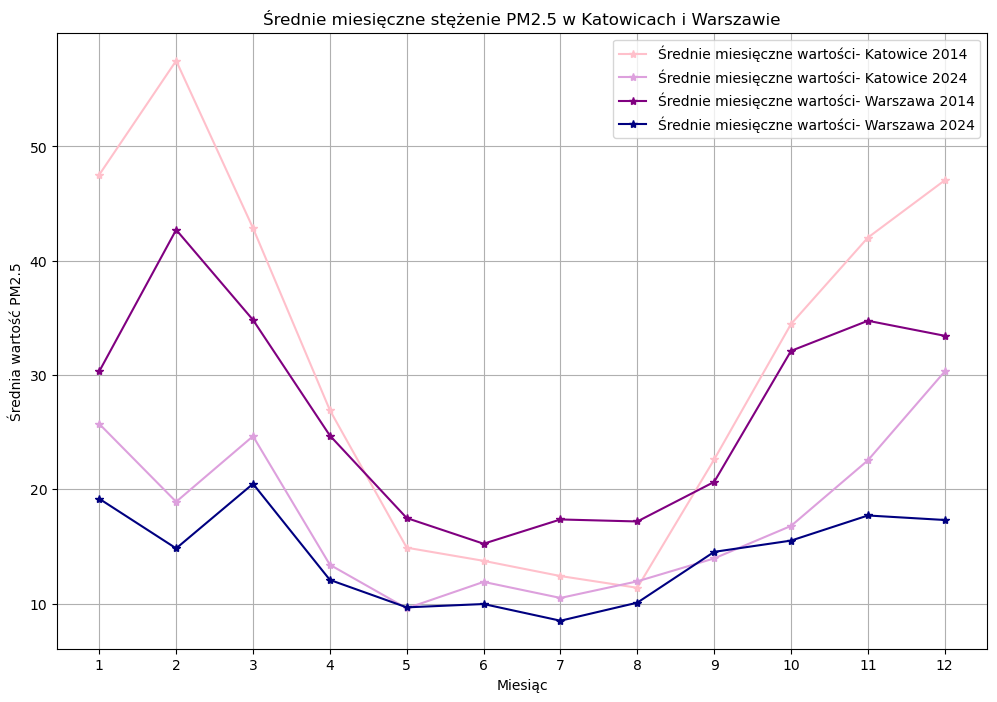

In [90]:
#Rysuję wykres:
import matplotlib.pyplot as plt

kat_2014 = kat_srednie.xs(2014, level='Rok')
kat_2024 = kat_srednie.xs(2024, level='Rok')
wwa_2014 = wwa_srednie.xs(2014, level='Rok')
wwa_2024 = wwa_srednie.xs(2024, level='Rok')

plt.figure(figsize=(12,8))

#Rysuję ustawiajac x jako miesiace (indeksy), a y jako średnie wartości (values). 
plt.plot(kat_2014.index, kat_2014.values, marker='*', color = "pink", label='Średnie miesięczne wartości- Katowice 2014')
plt.plot(kat_2024.index, kat_2024.values, marker='*', color = "plum", label='Średnie miesięczne wartości- Katowice 2024')
plt.plot(wwa_2014.index, wwa_2014.values, marker='*', color = "purple", label='Średnie miesięczne wartości- Warszawa 2014')
plt.plot(wwa_2024.index, wwa_2024.values, marker='*', color = "navy", label='Średnie miesięczne wartości- Warszawa 2024')

plt.xlabel('Miesiąc')
plt.ylabel('Średnia wartość PM2.5')
plt.title('Średnie miesięczne stężenie PM2.5 w Katowicach i Warszawie')
plt.xticks(range(1,13))
plt.grid(True)
plt.legend()
plt.show()


Opis i interpretacja wykresu: 
Widać, że najwyższe średnie pomiary zostały zebrane w Warszawie w 2014 roku. Najniższe średnie stężenie zauważono natomiast w Katowicach w 2024. W Warszawie i Katowicach w roku 2014 zauważyć można gwałtowny wzrost na przestrzeni stycznia i lutego, a spadek od lutego do czerwca. W 2014 zaś widać spadek od stycznia do lutego. Na każdym z wykresów zauważyć można wzrost stężenia od października do listopada. 

## Zadanie 3 - Mykyta Khrabust

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

/tmp/ipykernel_6128/401082450.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  srednie_po_stacjach = miesieczne_srednie.groupby(level="Miejscowość", axis=1).mean()


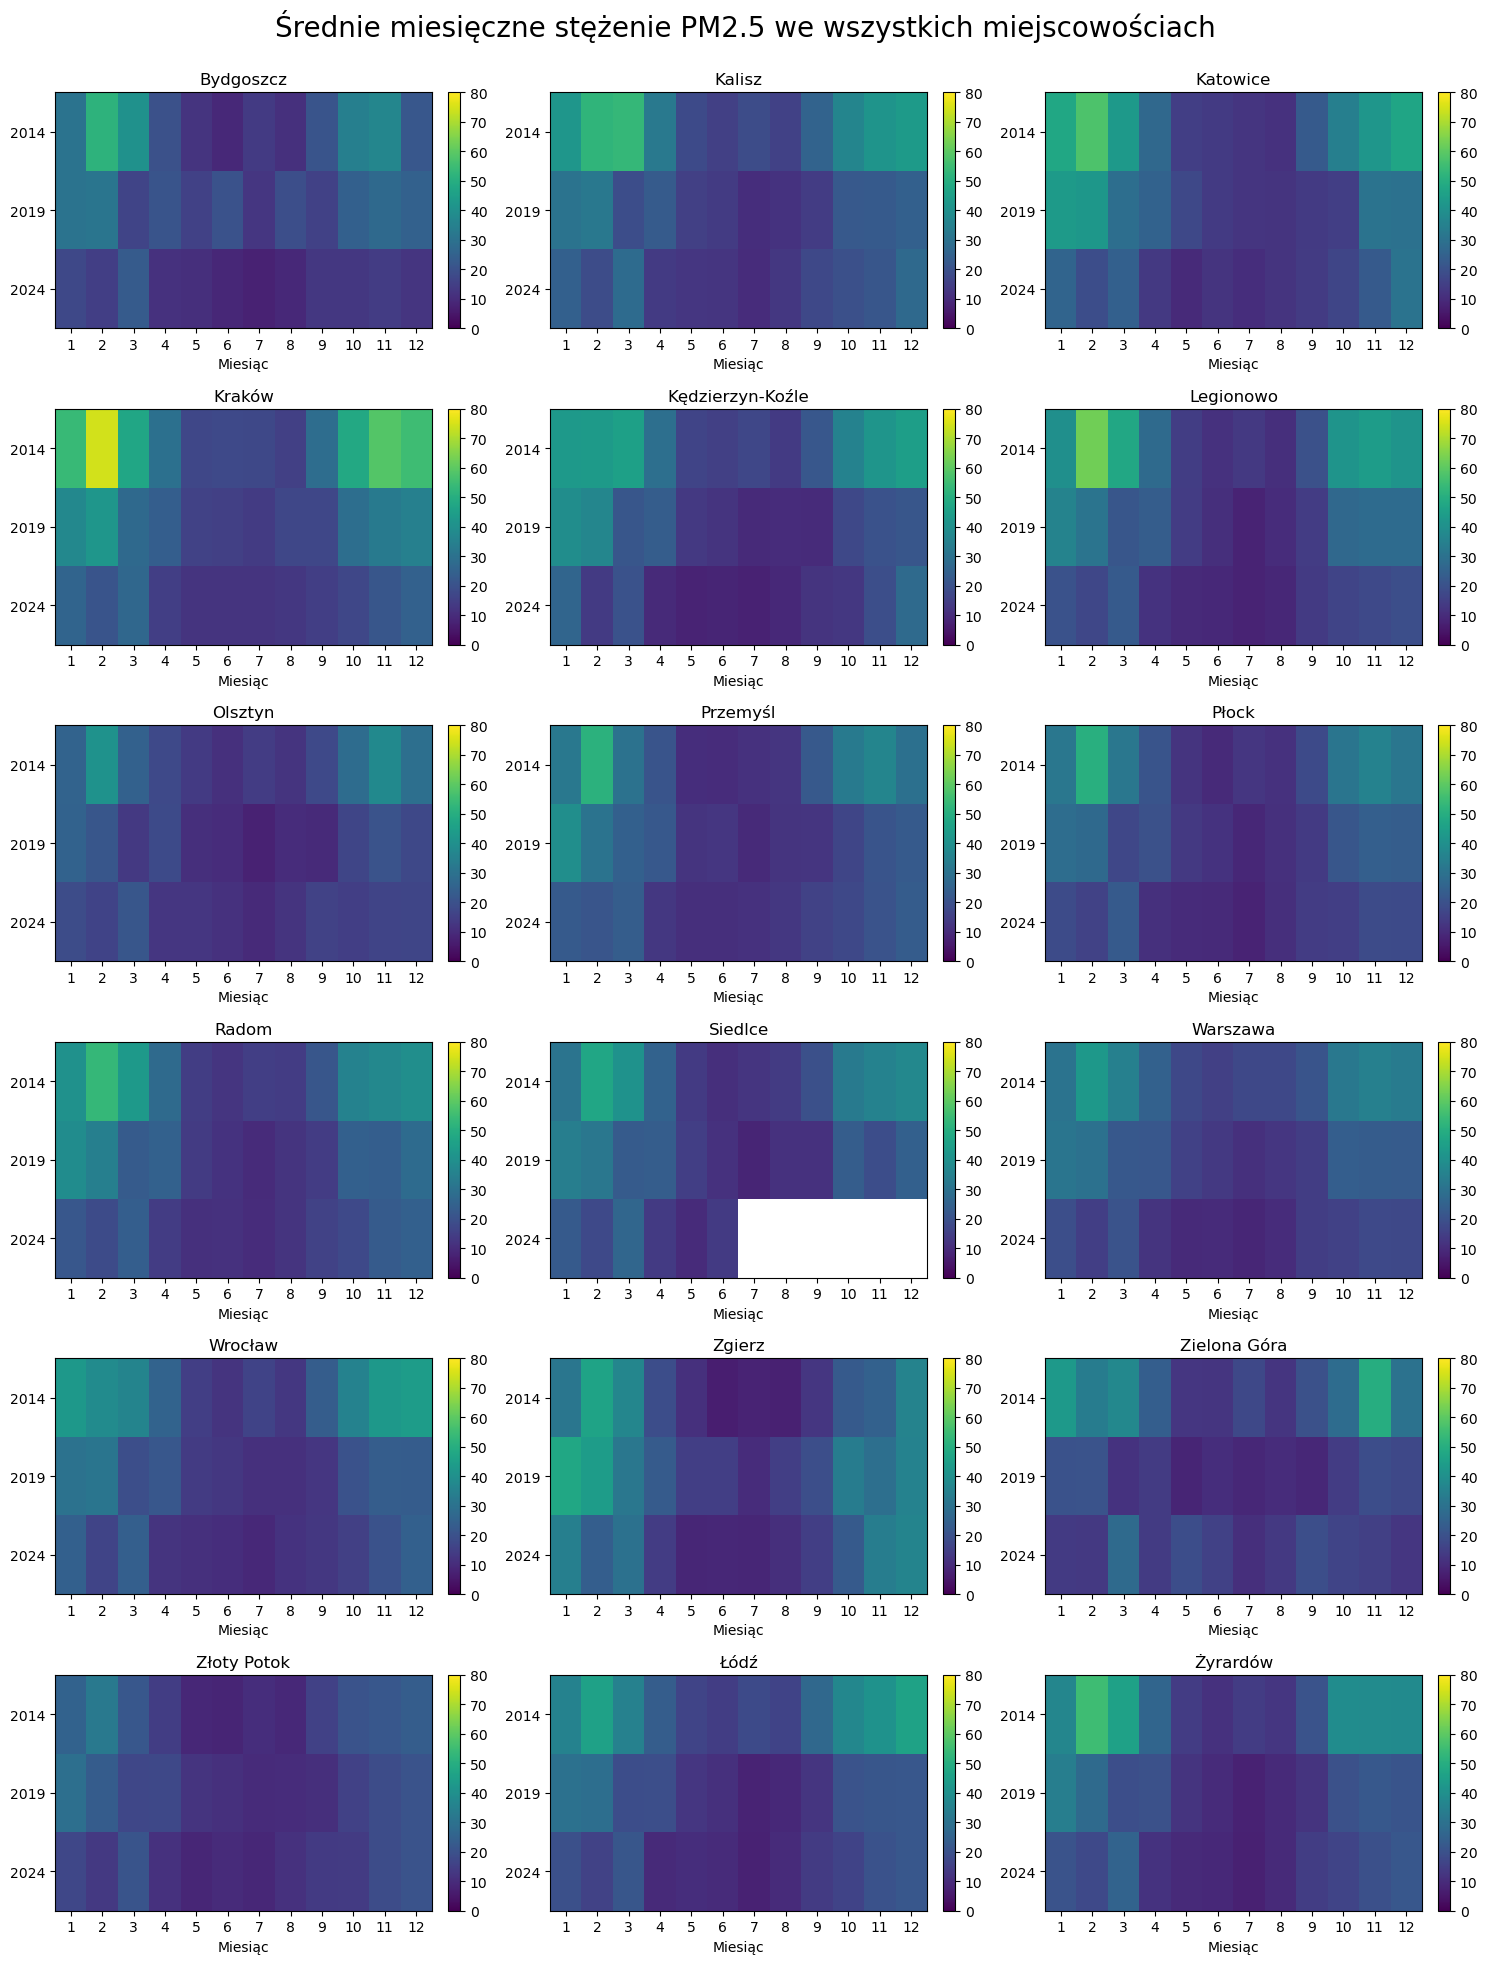

In [91]:
miesieczne_srednie = df_pomiary.groupby([df_pomiary.index.year, df_pomiary.index.month]).mean()
srednie_po_stacjach = miesieczne_srednie.groupby(level="Miejscowość", axis=1).mean()

years = [2014, 2019, 2024]
miejscowosci = srednie_po_stacjach.columns.to_list()

fig, axes = plt.subplots((len(miejscowosci)) // 3, 3, figsize=(15, 20))
fig.suptitle("Średnie miesięczne stężenie PM2.5 we wszystkich miejscowościach",fontsize=20)
for nr in range(len(miejscowosci)):
    df_heat = pd.concat([srednie_po_stacjach.loc[y, miejscowosci[nr]] for y in years],axis=1).T

    df_heat.index = years
    df_heat.columns.names = ['Miesiac']
    df_heat.index.names = ['Rok']
    # x,y to współrzędne każdego wykresu w tabeli 3x6
    y = nr//3
    x = nr%3

    hm = axes[y][x].imshow(df_heat, aspect='auto',vmin=0, vmax=80)
    axes[y][x].set_title(miejscowosci[nr])
    axes[y][x].set_xticks(range(12))
    axes[y][x].set_xticklabels(range(1, 13))
    axes[y][x].set_yticks(range(len(years)))
    axes[y][x].set_yticklabels(years)
    axes[y][x].set_xlabel("Miesiąc")
    cbar = fig.colorbar(hm, ax=axes[y][x], fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0, 0, 1, 0.98])


In [92]:
srednie_po_stacjach["Katowice"]

Data poboru danych  Data poboru danych
2014                1                     47.531587
                    2                     57.502297
                    3                     42.855405
                    4                     26.925608
                    5                     14.893387
                    6                     13.743375
                    7                     12.411844
                    8                     11.385135
                    9                     22.610570
                    10                    34.464336
                    11                    42.026389
                    12                    47.040377
2019                1                     43.471370
                    2                     42.289597
                    3                     28.847650
                    4                     25.093859
                    5                     17.455341
                    6                     13.626209
                    7    

### Interpretacja
We wszystkich miastach i we wszystkich latach stężenie PM2.5 jest większe w chłodnej połowie roku, co można wyjaśnić emisjami z elektrowni cieplnych i pieców domowych.

Na szczęście wszędzie widoczna jest tendencja do zmniejszania się stężenia w ciągu 10 lat.

## Zadanie 4 - Mykyta Khrabust

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

In [93]:
norma_dobowa = 15

In [94]:
#Grupujemy po dniach
dzienne_max = df_pomiary.groupby([df_pomiary.index.year, df_pomiary.index.month,df_pomiary.index.day]).max()
dzienne_max.index.names  = ["Rok","Miesiąc","Dzień"]
dzienne_max.head()

Kod stacji         DsWrocAlWisn KpBydPlPozna LdLodzCzerni LdZgieMielcz  \
Miejscowość             Wrocław    Bydgoszcz         Łódź       Zgierz   
Rok  Miesiąc Dzień                                                       
2014 1       1            152.0   116.214424    210.36467   119.696114   
             2             92.0    82.190231    70.359055    69.565697   
             3             92.0    64.930031    67.034363    54.652084   
             4             54.0     84.42363    63.027267    63.057362   
             5             54.0    50.976383    76.145187   117.091942   

Kod stacji         LuZielKrotka MpKrakAlKras MpKrakBulwar MzLegZegrzyn  \
Miejscowość        Zielona Góra       Kraków       Kraków    Legionowo   
Rok  Miesiąc Dzień                                                       
2014 1       1              NaN        172.0        142.0       103.07   
             2              NaN        215.0        150.0        267.3   
             3              NaN        206.0        180.0        85.25   
             4              NaN        212.0        188.0       137.06   
             5              NaN        128.0        131.0        85.47   

Kod stacji         MzPlocMiReja MzRadTochter MzSiedKonars MzWarAlNiepo  \
Miejscowość               Płock        Radom      Siedlce     Warszawa   
Rok  Miesiąc Dzień                                                       
2014 1       1             65.1        97.59        38.46   100.325798   
             2            70.73       141.57         44.2    61.724205   
             3            90.24        81.29        100.0    68.245979   
             4            74.29       131.81        111.6    67.127922   
             5            55.34       139.27        83.47    67.941765   

Kod stacji         MzWarWokalna MzZyraRoosev     OpKKozBSmial PkPrzemGrunw  \
Miejscowość            Warszawa     Żyrardów Kędzierzyn-Koźle     Przemyśl   
Rok  Miesiąc Dzień                                                           
2014 1       1            63.49          NaN            146.0       81.771   
             2            64.53        109.3             80.0       93.624   
             3             64.3        72.22             54.0       132.41   
             4            67.63        93.46             83.0       164.77   
             5            57.64       115.85             55.0       124.94   

Kod stacji         SlKatoKossut SlZlotPotLes WmOlsPuszkin WpKaliSawick  
Miejscowość            Katowice  Złoty Potok      Olsztyn       Kalisz  
Rok  Miesiąc Dzień                                                      
2014 1       1            124.0         62.0    84.121582         88.7  
             2            167.0         60.0    54.454487         99.8  
             3             77.0         55.0    68.606911         83.8  
             4              NaN         51.0    73.057579         54.9  
             5              NaN         51.0     39.80051         58.2

#### Sanity check

In [95]:
print(dzienne_max.shape)
for y in years:
    print(f"Liczba dni w lutym {y}: ",(dzienne_max.loc[(y,2)]).shape[0])

(1096, 20)
Liczba dni w lutym 2014:  28
Liczba dni w lutym 2019:  28
Liczba dni w lutym 2024:  29


W dataframe mamy 1096 wierszy, czyli 3*365 + 1 = 1096 (bo 2024 był rokiem przestępnym)  **Zgadza się**

In [96]:
ile_dni_wiecej_normy = pd.DataFrame(index=years, columns=dzienne_max.columns)
# Tworzę osobny dataframe zawierający liczbę dni, w których przekroczono normę dla każdej stancji w każdym roku

for year in years:
    df_year = dzienne_max.loc[year]
    ile_dni_wiecej_normy.loc[year] = (df_year > norma_dobowa).sum() #Liczę ilość szukanych dni

ile_dni_wiecej_normy

Kod stacji,DsWrocAlWisn,KpBydPlPozna,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBulwar,MzLegZegrzyn,MzPlocMiReja,MzRadTochter,MzSiedKonars,MzWarAlNiepo,MzWarWokalna,MzZyraRoosev,OpKKozBSmial,PkPrzemGrunw,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick
Miejscowość,Wrocław,Bydgoszcz,Łódź,Zgierz,Zielona Góra,Kraków,Kraków,Legionowo,Płock,Radom,Siedlce,Warszawa,Warszawa,Żyrardów,Kędzierzyn-Koźle,Przemyśl,Katowice,Złoty Potok,Olsztyn,Kalisz
2014,316,313,351,302,301,365,341,327,312,343,338,339,336,335,329,325,342,291,302,348
2019,324,320,287,352,264,361,341,313,304,327,305,350,273,288,285,306,317,292,270,337
2024,310,230,263,274,309,319,307,259,252,302,136,282,242,279,220,300,300,294,266,299


In [97]:
ile_dni_wiecej_normy = ile_dni_wiecej_normy.drop(('MzSiedKonars', 'Siedlce'), axis=1)
#Postanowiłem usunąć z df dane stacji MzSiedKonars w Siedlcach, ponieważ na wykresie z zadania 3 widać,
# że brakuje tam pomiarów w drugiej połowie roku.

In [98]:
rok = 2024
ile_maxmin = 3
mnnn = lambda x: x.nlargest(3).index.tolist()
max3_stacje = (ile_dni_wiecej_normy.loc[rok]).sort_values(ascending=False).head(ile_maxmin)
min3_stacje = (ile_dni_wiecej_normy.loc[rok]).sort_values(ascending=False).tail(ile_maxmin)

print("Stacje z największą liczbą dni z przekroczeniem normy dobowej\n",max3_stacje,"\n\nStacje z najmniejsa liczbą dni z przekroczeniem normy dobowej\n", min3_stacje)

Stacje z największą liczbą dni z przekroczeniem normy dobowej
 Kod stacji    Miejscowość 
MpKrakAlKras  Kraków          319
DsWrocAlWisn  Wrocław         310
LuZielKrotka  Zielona Góra    309
Name: 2024, dtype: object 

Stacje z najmniejsa liczbą dni z przekroczeniem normy dobowej
 Kod stacji    Miejscowość     
MzWarWokalna  Warszawa            242
KpBydPlPozna  Bydgoszcz           230
OpKKozBSmial  Kędzierzyn-Koźle    220
Name: 2024, dtype: object


In [99]:
wybrane_stacje = max3_stacje.index.tolist() + min3_stacje.index.tolist()
ile_dni_wybrane_stacje = ile_dni_wiecej_normy[wybrane_stacje]
ile_dni_wybrane_stacje

Kod stacji,MpKrakAlKras,DsWrocAlWisn,LuZielKrotka,MzWarWokalna,KpBydPlPozna,OpKKozBSmial
Miejscowość,Kraków,Wrocław,Zielona Góra,Warszawa,Bydgoszcz,Kędzierzyn-Koźle
2014,365,316,301,336,313,329
2019,361,324,264,273,320,285
2024,319,310,309,242,230,220


Text(0.5, 1.0, 'Liczbą dni z przekroczeniem normy dobowej = 15 µg/m³ stężenia PM2.5  dla 6 stacji')

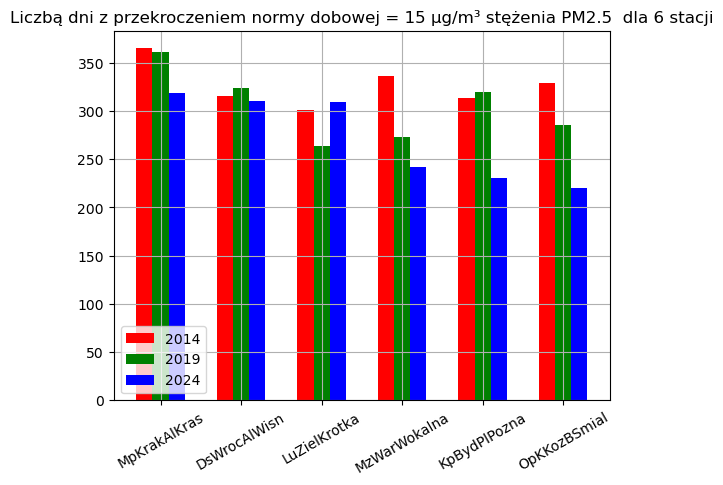

In [100]:
import numpy as np
x = np.arange(6)
width = 0.2


plt.bar(x-width, ile_dni_wybrane_stacje.loc[2014],width,color='red')
plt.bar(x, ile_dni_wybrane_stacje.loc[2019],width, color='green')
plt.bar(x+width, ile_dni_wybrane_stacje.loc[2024],width,color='blue')
plt.xticks(x, [stacja[0] for stacja in wybrane_stacje],rotation=30)
plt.grid()
plt.legend(years, loc='lower left')
plt.title(f"Liczbą dni z przekroczeniem normy dobowej = {norma_dobowa} µg/m³ stężenia PM2.5  dla 6 stacji")

### Interpretacja danych
Różnica w stężeniu między 3 stacjami o minimalnej liczbie dni a 3 stacjami o maksymalnej liczbie dni znacznie wzrosła z upływem czasu. W 2014 r. dla wszystkich 6 stacji wskaźniki przekraczały normę przez co najmniej 300 dni.
W 2024 r. dla wszystkich stacji o minimalnej liczbie dni wartość ta spadła poniżej 250, z widoczną tendencją spadkową, a dla pozostałych pozostała na poziomie powyżej 300.